# AIML Online Capstone - Pneumonia Detection Challenge

The goal is to build a pneumonia detection system, to locate the position of
inflammation in an image.

Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear
black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.
While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia
related.

In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates
that while pneumonia was determined not to be present, there was nonetheless some type of
abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They
contain a combination of header metadata as well as underlying raw image arrays for pixel data

# PART 1 - Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Project_Path = '/content/drive/My Drive/AIML - Projects/Capstone Project - CV1/'

Project_data_Path = '/content/drive/My Drive/AIML - Projects/Capstone Project - CV1/rsna-pneumonia-detection-challenge/'

Project_Train_Images_Path = Project_data_Path + 'stage_2_train_images/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cd /content
!pwd
!ls -lrt
!unzip "/content/drive/My Drive/AIML - Projects/Capstone Project - CV1/rsna-pneumonia-detection-challenge.zip" -d "/content/CapstoneProject" > /dev/null

Streaming output truncated to the last 5000 lines.
  inflating: /content/CapstoneProject/rsna-pneumonia-detection-challenge/stage_2_train_images/f868de0f-be9e-4da2-aee7-b0bc5b66e086.dcm  
  inflating: /content/CapstoneProject/__MACOSX/rsna-pneumonia-detection-challenge/stage_2_train_images/._f868de0f-be9e-4da2-aee7-b0bc5b66e086.dcm  
  inflating: /content/CapstoneProject/rsna-pneumonia-detection-challenge/stage_2_train_images/bfdbe64f-1ab9-4b72-a4b5-3ef6a057add2.dcm  
  inflating: /content/CapstoneProject/__MACOSX/rsna-pneumonia-detection-challenge/stage_2_train_images/._bfdbe64f-1ab9-4b72-a4b5-3ef6a057add2.dcm  
  inflating: /content/CapstoneProject/rsna-pneumonia-detection-challenge/stage_2_train_images/4dbc44ca-694a-4814-9a24-bc60c8d8d611.dcm  
  inflating: /content/CapstoneProject/__MACOSX/rsna-pneumonia-detection-challenge/stage_2_train_images/._4dbc44ca-694a-4814-9a24-bc60c8d8d611.dcm  
  inflating: /content/CapstoneProject/rsna-pneumonia-detection-challenge/stage_2_train_images/

In [ ]:
## Set the project path to the local Google Colab directory

Project_Path = '/content/CapstoneProject/'

Project_data_Path = '/content/CapstoneProject/rsna-pneumonia-detection-challenge/'

Project_Train_Images_Path = Project_data_Path + 'stage_2_train_images/'

In [ ]:
## Read the csv files in data frames
datainfo = pd.read_csv(Project_data_Path + "stage_2_detailed_class_info.csv")

datalabels = pd.read_csv(Project_data_Path + "stage_2_train_labels.csv")

In [ ]:
## Explore the data in the labels file
print (datalabels.head(5))
print (datalabels.tail(5))

                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
                                  patientId      x      y  width  height  \
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  185.0  298.0  228.0   379.0   
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba    NaN    NaN    NaN     NaN   
30224  c1f6b555-2eb1-4231-98f6-50a963976431    NaN    NaN    NaN     NaN   
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target  
30222       1  
30223       0  
30224       0  
30225       1  
3

In [ ]:
print (datalabels.shape)

(30227, 6)


In [ ]:
## Let's check the balance of target variable 
print (datalabels['Target'].value_counts())

0    20672
1     9555
Name: Target, dtype: int64


In [ ]:
## Let's check nulls in the dataframe
print (datalabels.isna().sum())

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64


There are no nulls in Target and patientId columns.

Columns x,y, width and height are having nulls for 20672 rows. 

Target column distribution: 20672 are pneumonia negative and 9555 are pneumonia positive. This is good proportion.

In [ ]:
from collections import Counter

DupPatients = datalabels.duplicated()

print ("Duplicate patients:  ", DupPatients.value_counts())

Duplicate patients:   False    30227
dtype: int64


In [ ]:
dfmultirowpatients = datalabels.groupby('patientId').filter(lambda x: len(x) > 2)

dfmultirowpatients.head

<bound method NDFrame.head of                                   patientId      x      y  width  height  \
122    03a9498c-549d-4e7d-800b-e74797f7f625  195.0  511.0  218.0   271.0   
123    03a9498c-549d-4e7d-800b-e74797f7f625  612.0  214.0  109.0    89.0   
124    03a9498c-549d-4e7d-800b-e74797f7f625  610.0  599.0  265.0   245.0   
144    040a0743-f663-4746-8224-f0e3bacc7ba5  294.0  228.0   87.0   144.0   
145    040a0743-f663-4746-8224-f0e3bacc7ba5  180.0  504.0  236.0   205.0   
...                                     ...    ...    ...    ...     ...   
30007  2cd0cbc4-bf35-49de-963e-8ee3fd08ca75  630.0  389.0  195.0    95.0   
30008  2cd0cbc4-bf35-49de-963e-8ee3fd08ca75  291.0  224.0  153.0   119.0   
30085  2f686840-18b3-45ac-a2bb-6140e3b0ac73  756.0  581.0  211.0   143.0   
30086  2f686840-18b3-45ac-a2bb-6140e3b0ac73  358.0  547.0  139.0   126.0   
30087  2f686840-18b3-45ac-a2bb-6140e3b0ac73  751.0  316.0  154.0   177.0   

       Target  
122         1  
123         1  
124      

In [ ]:
print ("No of patients with multiple rows:", dfmultirowpatients.size)

No of patients with multiple rows: 2454


In [ ]:
dfmultirowpatients['patientId'].value_counts()

7d674c82-5501-4730-92c5-d241fd6911e7    4
1c44e0a4-4612-438f-9a83-8d5bf919cb67    4
31764d54-ea3b-434f-bae2-8c579ed13799    4
ee820aa5-4804-4984-97b3-f0a71d69702f    4
0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d    4
                                       ..
3d895c52-0627-42b3-ba67-41a08f387da0    3
3c1fdc6b-2e9a-46f7-8dbd-28d4155f9b93    3
3a510377-9cb0-4fa2-97fd-3c663e64ec9f    3
36d7ebd2-a4e5-42d1-bde0-c7699da0b152    3
2f686840-18b3-45ac-a2bb-6140e3b0ac73    3
Name: patientId, Length: 132, dtype: int64

In [ ]:
print ("No of patients with multiple anomalies in the X=ray: ",dfmultirowpatients['patientId'].nunique())

No of patients with multiple anomalies in the X=ray:  132


Total 132 patients are having more than 1 anomalies.

Total 2454 rows in the csv in all represent num of patches with multiple anomalies.

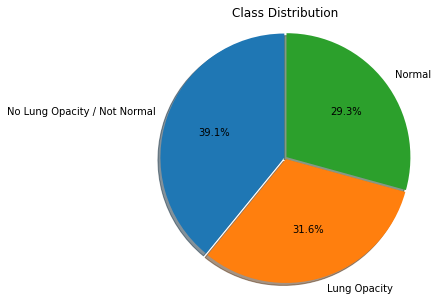

In [ ]:
##Let's display the distribution of the target variable - 'Class' from datainfo dataframe
label_count=datainfo['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

In [ ]:
Train_df=datainfo.merge(datalabels, left_on='patientId', right_on='patientId', how='inner' )
Train_df.sample(5)

patientId                         class  \
33039  ec903e13-0397-46d8-8b5b-194631e31bf6  No Lung Opacity / Not Normal   
4414   366c5768-5fba-4ba1-8532-082d3ba3c9bf                  Lung Opacity   
6946   429491d5-4da9-4342-aeea-4f5c38f3de3d  No Lung Opacity / Not Normal   
3906   3454c720-b91a-4605-99cb-b0e207aa4df7                        Normal   
22752  ad587880-a108-4b52-bf4a-28d248bb1539                  Lung Opacity   

           x      y  width  height  Target  
33039    NaN    NaN    NaN     NaN       0  
4414   227.0  577.0  176.0   169.0       1  
6946     NaN    NaN    NaN     NaN       0  
3906     NaN    NaN    NaN     NaN       0  
22752  224.0  405.0  135.0   315.0       1

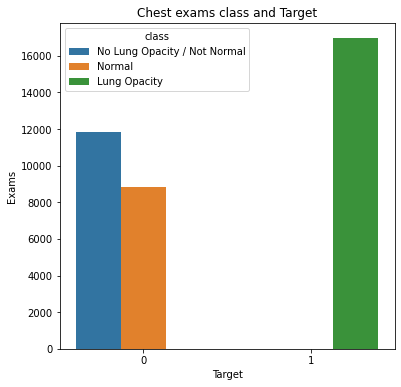

In [ ]:
fig, ax = plt.subplots(nrows=1,figsize=(6,6))
temp_data = Train_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': temp_data.values}, index=temp_data.index).reset_index()
sns.barplot(ax=ax, x = 'Target', y = 'Exams', hue='class', data = df)
plt.title("Chest exams class and Target")
plt.show()

In [ ]:
## Let's load the patients related data from the dcm files in the dataframe.
%pip install pydicom
import pydicom as dicom
from tqdm import tqdm

patient_info_df = pd.DataFrame(columns=['age','sex','patientId'])
for ix,id_ in tqdm(enumerate(datainfo['patientId'])):
    #age=dicom.read_file(os.path.join(Project_Train_Images_Path,
    #                               id_+'.dcm')).PatientAge
    age=dicom.read_file(Project_Train_Images_Path + id_ + '.dcm').PatientAge
    sex=dicom.read_file(Project_Train_Images_Path + id_ + '.dcm').PatientSex
                                   
    patient_info_df.loc[ix,'age']=age
    patient_info_df.loc[ix,'sex']=sex
    patient_info_df.loc[ix,'patientId'] = id_


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


30227it [03:42, 135.59it/s]


In [ ]:
patient_info_df.head(10)
patient_info_df_orig = patient_info_df.copy()

In [ ]:
##Merging this patient information with the exiting meta data
patient_info_df = pd.merge(datainfo,patient_info_df,on="patientId")
patient_info_df

patientId                         class age  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal  51   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal  48   
2      00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal  19   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal  28   
4      00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity  32   
...                                     ...                           ...  ..   
37624  c1f6b555-2eb1-4231-98f6-50a963976431                        Normal  45   
37625  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity  72   
37626  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity  72   
37627  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity  72   
37628  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity  72   

      sex  
0       F  
1       F  
2       M  
3       M  
4       F  
...    ..  
37624   M  
37625   F  
37626   F  
37627   F  
37628   F  

[37629 rows x 4 columns]

In [ ]:
## Merge the labels data into the info data 
merged_data_info = pd.merge(datalabels,patient_info_df,on="patientId")
merged_data_info.tail(10)

patientId      x      y  width  height  \
53449  c1edf42b-5958-47ff-a1e7-4f23d99583ba    NaN    NaN    NaN     NaN   
53450  c1f6b555-2eb1-4231-98f6-50a963976431    NaN    NaN    NaN     NaN   
53451  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
53452  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
53453  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
53454  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
53455  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   
53456  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   
53457  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   
53458  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target         class age sex  
53449       0        Normal  46   F  
53450       0        Normal  45   M  
53451       1  Lung Opacity  72   F  
53452       1  Lung Opacity  72   F  
53453       1  Lung Opacity  72   F  
53454       1  Lung Opacity  72   F  
53455       1  Lung Opacity  72   F  
53456       1  Lung Opacity  72   F  
53457       1  Lung Opacity  72   F  
53458       1  Lung Opacity  72   F

In [ ]:
print(merged_data_info.shape)
print(merged_data_info.isna().sum())

(53459, 9)
patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
age              0
sex              0
dtype: int64


In [ ]:
merged_data_info['age'] = merged_data_info['age'].astype('int64')
print('Minimum Age in the dataset:', merged_data_info['age'].min())
print('Maximum Age in the dataset', merged_data_info['age'].max())

Minimum Age in the dataset: 1
Maximum Age in the dataset 155


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


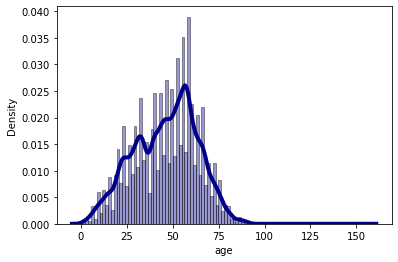

In [ ]:
## Check the distribution of age using histogram
sns.distplot(merged_data_info['age'], hist=True, kde=True, 
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [ ]:
merged_data_info['age'].value_counts()

58     2035
56     1715
52     1439
40     1422
46     1271
       ... 
148       1
151       1
153       1
150       1
155       1
Name: age, Length: 97, dtype: int64

Text(0.5, 1.0, 'Age by Gender variable')

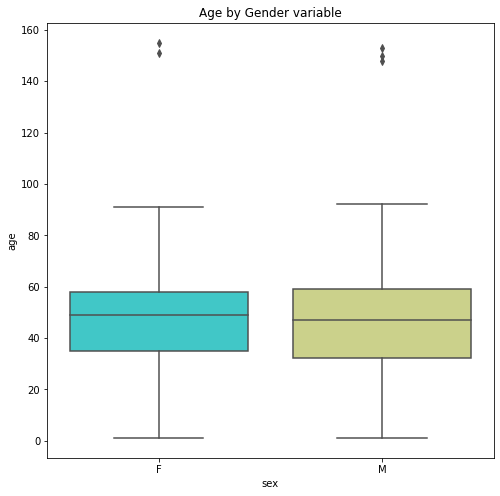

In [ ]:
## Let's plot the box plot for the age distribution for male and females in the patients
## Plot the Box Plot for L_angle for three different values of Class variable

plt.figure(figsize=(8,8))
sns.boxplot(x='sex',y='age',data=merged_data_info, palette='rainbow')
plt.title("Age by Gender variable")

- The Age distribution is fairly even.
- Age distribution between male patients and female patients also looks fairly even.
- Few outliers with age between 140 and 160 are seen for both males and female patients


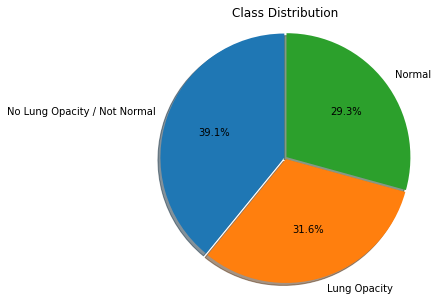

In [ ]:
## Let's evaluate the target distribution from the info worksheet
label_count=datainfo['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

- Class distribution is highly imbalanced with the patients with confirmed Lung Opacity being only 22.5 % of the population

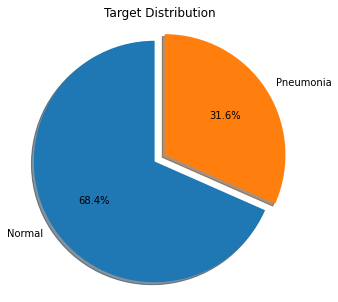

In [ ]:
# lets take a look at our Target Distribution from the labels csv provided
label_count=datalabels['Target'].value_counts()
explode = (0.1,0.0)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=['Normal','Pneumonia'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

- Target distribution seems slightly imbalanced with normal being 68% and positive detected being 31%.

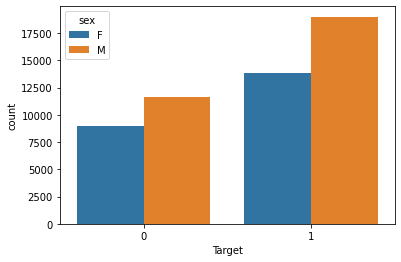

In [ ]:
## Let's check the distribution of the target for males and females
sns.countplot(x=merged_data_info['Target'], hue=merged_data_info['sex'])

- Male represetation is slightly higher for both positive and negative cases

In [ ]:
print ("Path for the first training image: ",trainfilelist[0])

print ("No of images in training data: ",len(trainfilelist))



Path for the first training image:  /content/CapstoneProject/rsna-pneumonia-detection-challenge/stage_2_train_images/0f510183-11b0-4356-b8ae-24ac9e3814c4.dcm
No of images in training data:  26684


In [ ]:
## Let's create two seperate dataframes for pneumonia and non pneumonia patients

DfPositivePneunomia = datalabels[datalabels['Target'] == 1]

DfNegativePneunomia = datalabels[datalabels['Target'] == 0]

print (datalabels.head())

print (DfPositivePneunomia.head())

print (DfNegativePneunomia.tail())

                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
                               patientId      x      y  width  height  Target
4   00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
8   00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9   00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1
14  00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0   135.0       1
                                  patientId   x   y  width  height  Ta

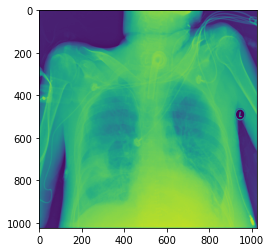

In [ ]:
## Let's print one single image
from PIL import Image

ds = dicom.dcmread(trainfilelist[0])

pil_image=Image.fromarray(ds.pixel_array)

imgarray = np.array(pil_image)

plt.imshow(imgarray)


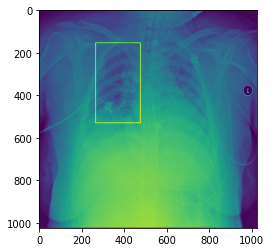

In [ ]:
from PIL import ImageDraw as D

## Let's print one image with boundary box
ds = dicom.dcmread(Project_Train_Images_Path + DfPositivePneunomia['patientId'][4] + '.dcm')

X0 = DfPositivePneunomia['x'][4]
Y0 = DfPositivePneunomia['y'][4]
X1 = DfPositivePneunomia['x'][4] + DfPositivePneunomia['width'][4]
Y1 = DfPositivePneunomia['y'][4] + DfPositivePneunomia['height'][4]



pil_image=Image.fromarray(ds.pixel_array)

draw=D.Draw(pil_image)

draw.rectangle([(X0,Y0),(X1,Y1)],outline="white", width = 4)

imgarray = np.array(pil_image)

plt.imshow(imgarray)


In [ ]:
## Define a function to plot images

def PlotImage (ImageData):
  ## ImageData is the dictionary where key is the patientid and value is the list of arrays with x0, y0 and x1, y1 cordinates.
  ## If the length of the list is zero, then there is no pneumonia for the patient
  ## Expectation is that this functiona will print the images in the dictionary and highlight the infected areas.

  fig = plt.figure(figsize=(24, 30))

  rows = 4
  columns = 4

  i = 0

  for PatientID in ImageData:

    i = i+1
    ImagePath = Project_Train_Images_Path + PatientID + '.dcm'
    ds = dicom.dcmread(ImagePath)
    data_row_img_data = dicom.read_file(ImagePath)
    modality = data_row_img_data.Modality
    age = data_row_img_data.PatientAge
    sex = data_row_img_data.PatientSex

    pil_image=Image.fromarray(ds.pixel_array)
    draw=D.Draw(pil_image)

    PneumoniaDetected = True

    BoundingBox = ImageData[PatientID]

    
    if (len(BoundingBox) == 0):
      ## If BoundingBox is not present, then this is Normal patient
      PneumoniaDetected = False
    else:
      ## If BoundingBox is present, then this is Pneunomia Infected patient
      PneumoniaDetected = True
      ## Draw as many rectangles as many bounding Boxes present
      for iCnt in range(len(BoundingBox)):
        draw.rectangle([(BoundingBox[iCnt][0],BoundingBox[iCnt][1]),(BoundingBox[iCnt][2],BoundingBox[iCnt][3])],outline="white", width = 4)
      
    imgarray = np.array(pil_image)

    fig.add_subplot(rows, columns, i)
    
    plt.imshow(imgarray)
    plt.axis('off')
    plt.title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}'.format(
                PatientID,
                modality, age, sex, PneumoniaDetected  
                ))
  

  plt.show()


In [ ]:
## Let's prepare ImageData dictionary to load the data and show it
ImageData = {}

## Let's populate the dictionary with three images where Pneumonia is not detected
iCount = 0
iTargetCount = 3
for ind in DfNegativePneunomia.index:
  BoundingBox = []

  if (iCount == iTargetCount):
   break

  ImageData[DfNegativePneunomia['patientId'][ind]]= BoundingBox

  iCount +=1

## Let's set three images with a single BoundingBox

## Let's set three images with multiple BoundingBoxes
## Let's refer to the dataframe - dfmultirowpatients
iCount = 0
iTargetCount = 10
for ind in dfmultirowpatients.index:
  BoundingBoxList = []

  if (iCount == iTargetCount):
    break

  df = dfmultirowpatients.loc[dfmultirowpatients['patientId'] == dfmultirowpatients['patientId'][ind]]

  for indInternal in df.index:
    BoundingBoxArr = np.zeros(shape=(4,1))
    BoundingBoxArr[0] = dfmultirowpatients['x'][indInternal]
    BoundingBoxArr[1] = dfmultirowpatients['y'][indInternal]
    BoundingBoxArr[2] = dfmultirowpatients['x'][indInternal] + dfmultirowpatients['width'][indInternal] 
    BoundingBoxArr[3] = dfmultirowpatients['y'][indInternal] + dfmultirowpatients['height'][indInternal] 
    BoundingBoxList.append(BoundingBoxArr)
  #ImageData[DfNegativePneunomia['patientId'][ind]]= BoundingBox

  ImageData[dfmultirowpatients['patientId'][ind]]= BoundingBoxList

  iCount +=1

dfSingleRowpatients = datalabels.groupby('patientId').filter(lambda x: len(x) == 1)

dfSingleRowpatients = dfSingleRowpatients.loc[dfSingleRowpatients['Target'] == 1]

## Let's load a couple of patients with a songle BoundingBox

iCount = 0
iTargetCount = 4
for ind in dfSingleRowpatients.index:
  BoundingBoxList = []

  if (iCount == iTargetCount):
    break

  df = dfSingleRowpatients.loc[dfSingleRowpatients['patientId'] == dfSingleRowpatients['patientId'][ind]]

  for indInternal in df.index:
    BoundingBoxArr = np.zeros(shape=(4,1))
    BoundingBoxArr[0] = dfSingleRowpatients['x'][indInternal]
    BoundingBoxArr[1] = dfSingleRowpatients['y'][indInternal]
    BoundingBoxArr[2] = dfSingleRowpatients['x'][indInternal] + dfSingleRowpatients['width'][indInternal] 
    BoundingBoxArr[3] = dfSingleRowpatients['y'][indInternal] + dfSingleRowpatients['height'][indInternal] 
    BoundingBoxList.append(BoundingBoxArr)
  #ImageData[DfNegativePneunomia['patientId'][ind]]= BoundingBox

  ImageData[dfSingleRowpatients['patientId'][ind]]= BoundingBoxList

  iCount +=1


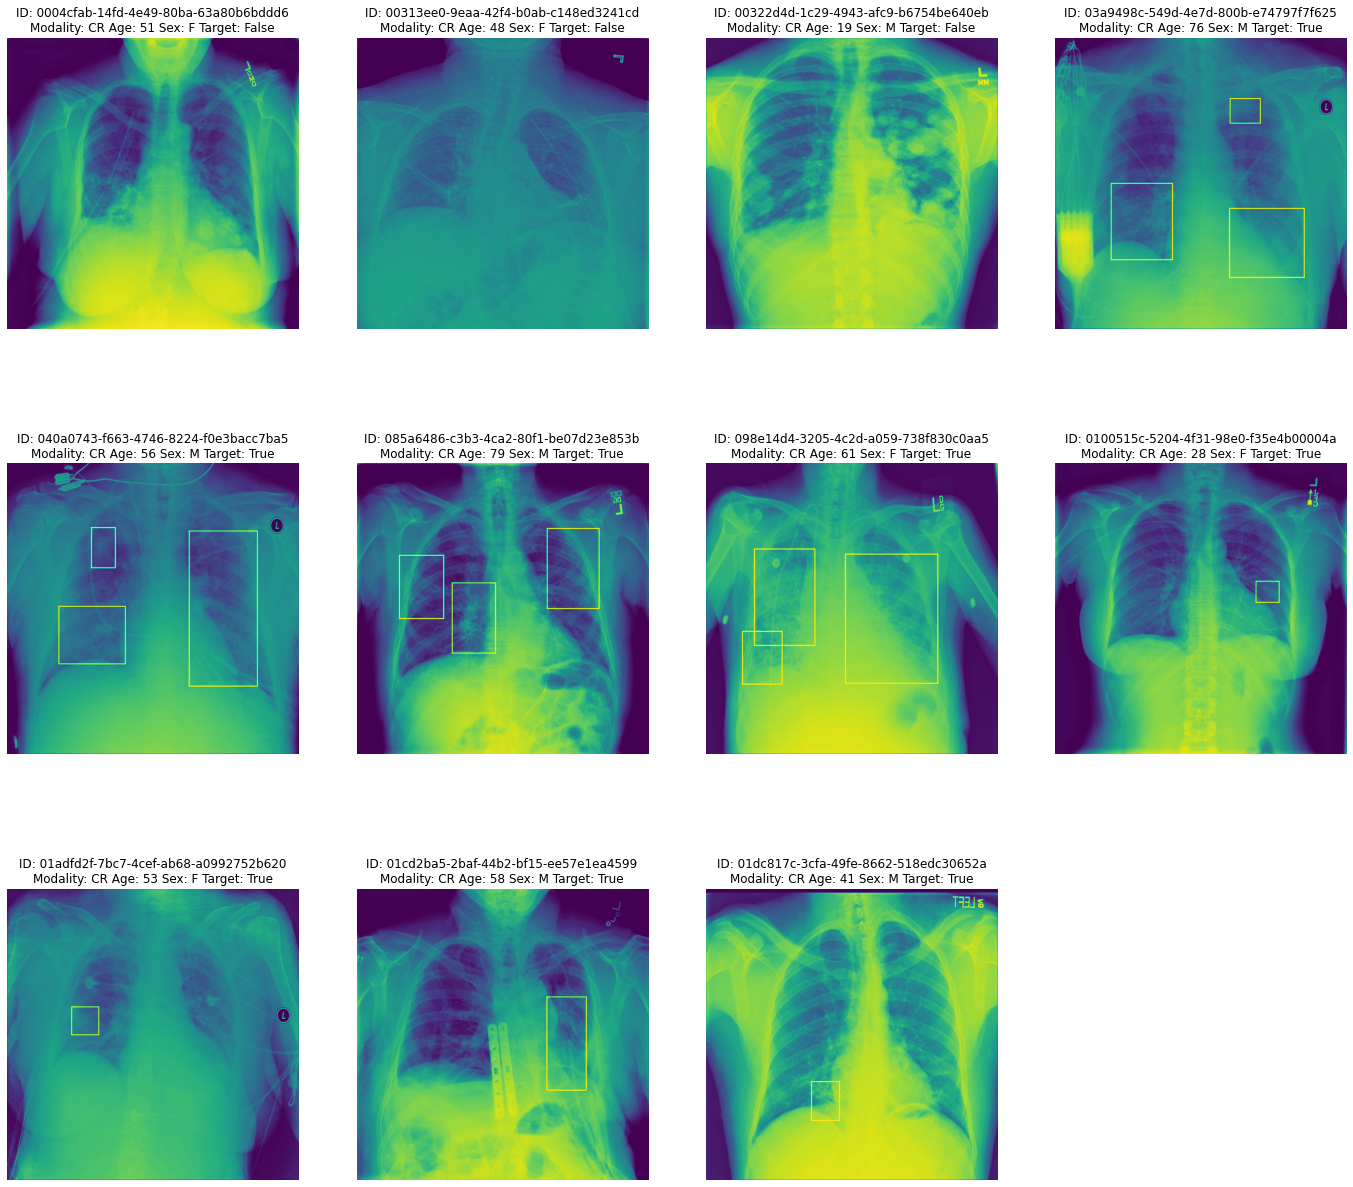

In [ ]:
## Invoke the function to plot the images
## Images with different variations are plotted
PlotImage(ImageData)

Let us write some code to load the binary image data in a dictionary

The key of the dictionary would be the patientID and value would be the array of size 32x32 which represents the image of the Xray.

This data would be helpful in further model building

In [ ]:
ImagesData = LoadImages (trainfilelist)

100%|██████████| 26684/26684 [07:37<00:00, 58.32it/s]


In [ ]:
## Parallel processing is implemented to improve the performance of overall IO activity
import time
from multiprocessing import Pool

if __name__ == "__main__":
    starttime = time.time()
    pool = Pool()
    result = pool.map_async(LoadImages, chunked_list)
    endtime = time.time()
    print("main script")
    Images = result.get()
    print("end main script")

    print("Time taken {endtime-starttime} seconds")

## At the end of this execution, Images would be the list of dictionary objects.
## Each object would have the key as patientID and value as the image data

  0%|          | 3/11684 [00:00<06:34, 29.64it/s]

main script


100%|██████████| 15000/15000 [06:29<00:00, 38.47it/s]


end main script
Time taken {endtime-starttime} seconds


# PART 2 - Model Building

In [300]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [301]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pydicom as dcm
import math
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model

import cv2

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input 

import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence

import math

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnetProcess_input

In [302]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [303]:
!cd /content
!pwd
!ls -lrt
!unzip "/content/drive/My Drive/AIML - Projects/Capstone Project - CV1/rsna-pneumonia-detection-challenge.zip" -d "/content/CapstoneProject" > /dev/null

/content
total 12
drwxr-xr-x 1 root root 4096 Jun 15 13:42 sample_data
drwx------ 5 root root 4096 Jun 25 10:46 drive
drwxr-xr-x 4 root root 4096 Jun 25 10:46 CapstoneProject
replace /content/CapstoneProject/__MACOSX/._rsna-pneumonia-detection-challenge? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [304]:
Base_path = '/content/CapstoneProject/rsna-pneumonia-detection-challenge/'

## **Reading the Data Set and EDA**

In [305]:
## reading the labels data set and showing first few records
labels = pd.read_csv(Base_path + "stage_2_train_labels.csv")
labels.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [306]:
labels.shape
## There are 30227 records and 6 rows

(30227, 6)

In [307]:
labels.info()
## There are 30227 rows 
## there are 30277 target as well
## x ,y, WIdth and height count is 9555 , the others are null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [308]:
## we can see that all the null column values are with Target 0 indicating that those patients do not have penumonia
labels[labels.isnull().any(axis=1)].Target.value_counts()

0    20672
Name: Target, dtype: int64

In [309]:
## we can see that all the non null column values are with Target 1 indicating that those patients have pneumonia
labels[~labels.isnull().any(axis=1)].Target.value_counts()

1    9555
Name: Target, dtype: int64

In [310]:
## Distubution of Targets , there are 20672 records with no pneumonia and 9555 with pneumonia
labels.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

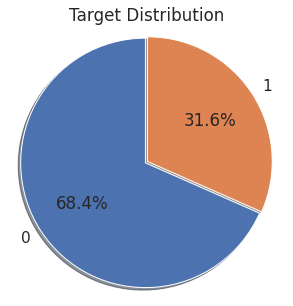

In [311]:
## Disturbution of Target, there are 31% of patients with pneumonia and the remaining are no pneumonia
## There is a class imbalance issue
label_count=labels['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

In [312]:
print("Are there Unique Patients In Data Set ?? " ,labels['patientId'].is_unique)
## There is no point in finding unique for x,y,width and height as there can be duplcaie values in them
## There are duplicate patients in the data set

Are there Unique Patients In Data Set ??  False


In [313]:
#labels.loc[labels.index.repeat(labels.patientId)]
duplicateRowsDF = labels[labels.duplicated(['patientId'])]
duplicateRowsDF.shape

## There are 3543 duplicates

(3543, 6)

In [314]:
duplicateRowsDF.head(2)

patientId      x      y  width  height  Target
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

In [315]:
## Examining one of the patient id which is duplicate , we can see that the x,y, widht and height is not the same
## This indicates that the same patient has two bounding boxes in the same dicom image
labels[labels.patientId=='00436515-870c-4b36-a041-de91049b9ab4']

patientId      x      y  width  height  Target
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1

In [316]:
labels[labels.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

patientId      x      y  width  height  Target
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

# **Reading the class Info Data Set**

In [317]:
## Reading the classes label , 
class_labels = pd.read_csv(Base_path + "stage_2_detailed_class_info.csv")
class_labels.head()


patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [318]:
class_labels.shape
## There are 30277 rows and two columns , 30277 rows same as the labels data set

(30227, 2)

In [319]:
class_labels.info()
## There are no null columns 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [320]:
class_labels['class'].value_counts()

## there are 8851 normal cases , person with lung opactiry are 9555 and No Lung Opacity / Not Normal are 11821 

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

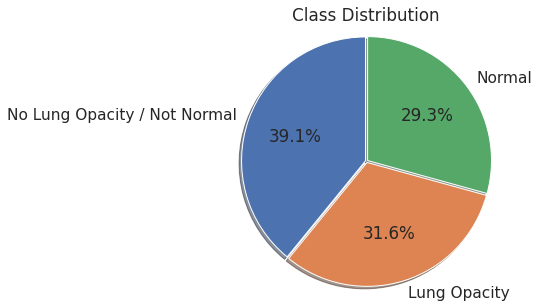

In [321]:
## Disturbution of Classes, there are 39% of patients with No Lung opacity , 29.3% Normal 
## and the remaining are with Lung Opacity
label_count=class_labels['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

In [322]:

#labels.loc[labels.index.repeat(labels.patientId)]
duplicateClassRowsDF = class_labels[class_labels.duplicated(['patientId'])]
duplicateClassRowsDF.shape

## There are 3543 duplicates similar to the labels dataset

(3543, 2)

In [323]:
duplicateClassRowsDF.head(2)

patientId         class
5  00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity

In [324]:
## The same patient id has the same class even though they are duplicate
class_labels[class_labels.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

patientId         class
8  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity

Merging the class and labels data set into training dataset

In [325]:
# Conctinating the two dataset - 'labels' and 'class_labels':
training_data = pd.concat([labels, class_labels['class']], axis = 1)

training_data.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

Text(0.5, 1.0, 'Class and Target  Distrubution')

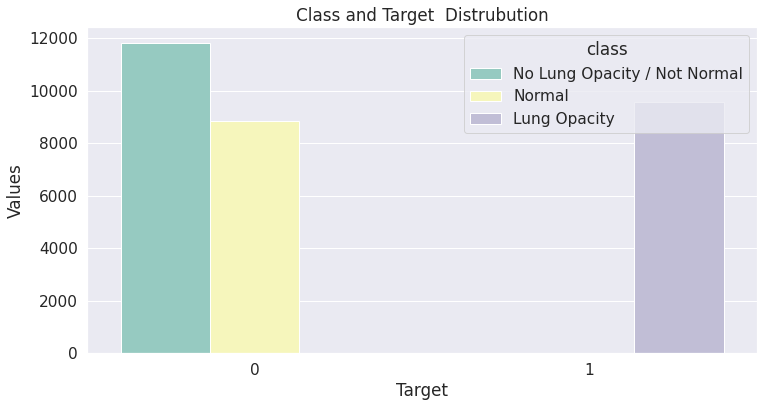

In [326]:
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'Set3')
plt.title('Class and Target  Distrubution')

## it shows that class distrubution grouped by Target 
## Target 0 has only Normal or No Lung Opacity class
## Target 1 has only Lung Opacity class

In [327]:
## ANalysing the dicom image
import matplotlib.patches as patches

def inspectImages(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        dcm_file = Base_path + 'stage_2_train_images/'+'{}.dcm'.format(patientImage)
        data_row_img_data = dcm.read_file(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\Bounds: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
            ax[i//3, i%3].add_patch(rect)

    plt.show()

Displaying Chest Xray Images of Patients who have Pneuomina

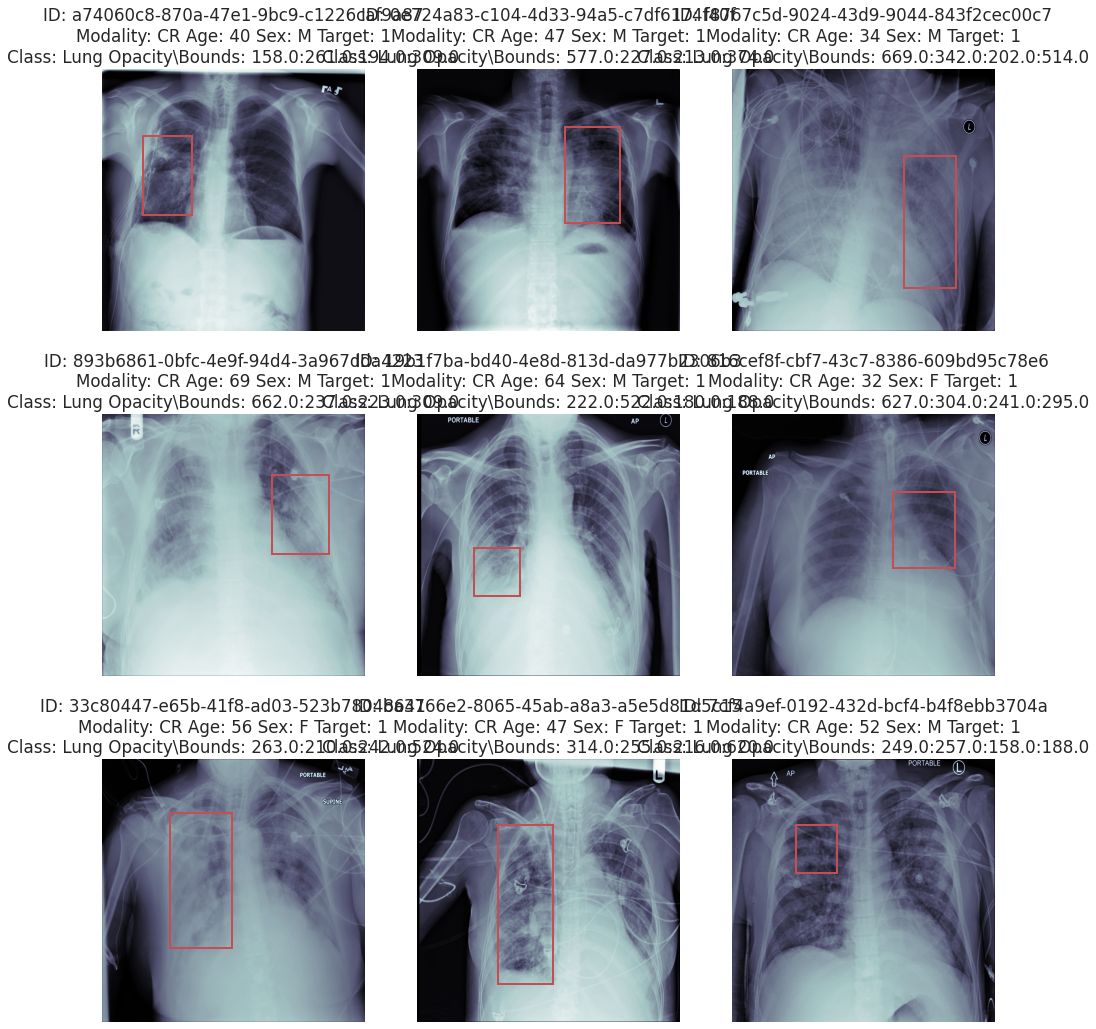

In [328]:
## checking few images which has pneuonia 
inspectImages(training_data[training_data['Target']==1].sample(9))

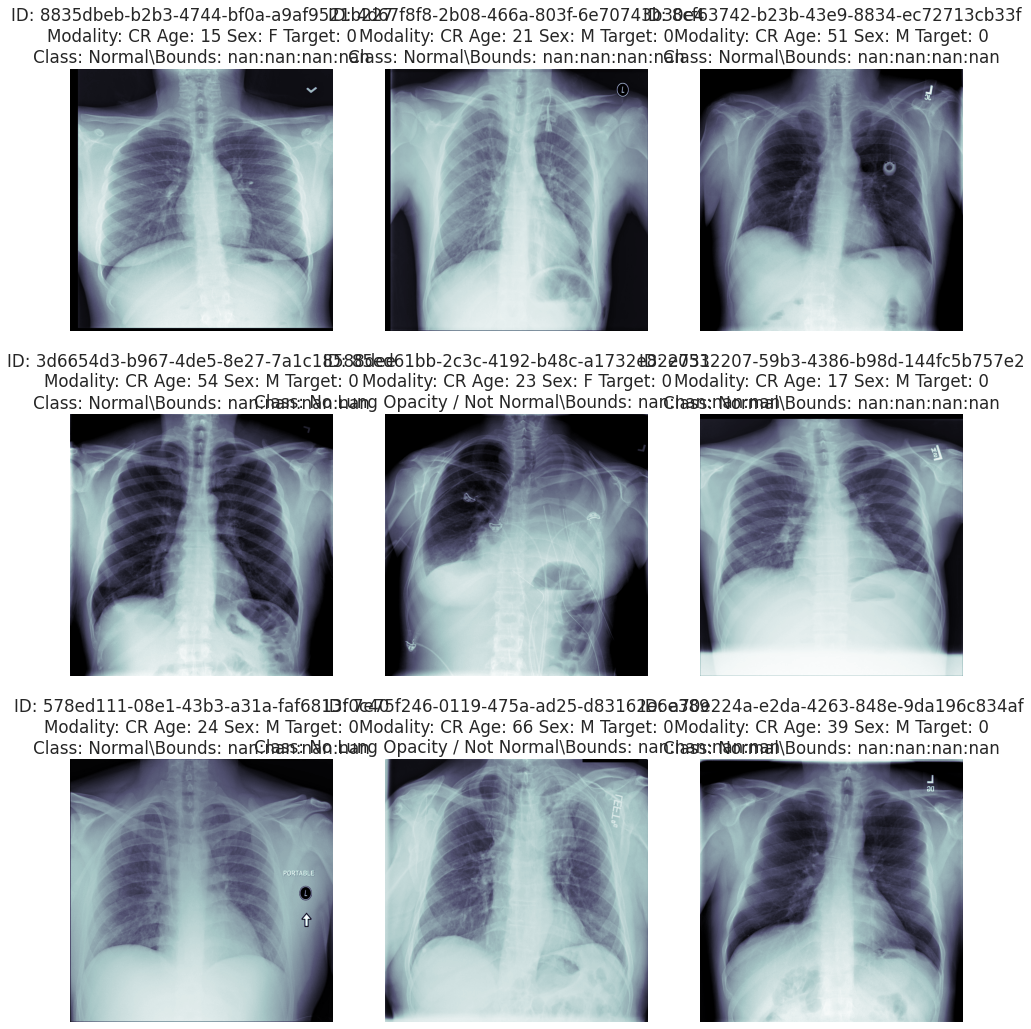

In [329]:
## checking few images which does not have pneuonia 
inspectImages(training_data[training_data['Target']==0].sample(9))

Reading the Dicom images meta data and appending it to the training set

In [330]:
## DCIM image contain the meta data alon with it, 
## Function to read the dcim data and appending to the resultset
def readDCIMData(rowData):
    dcm_file = Base_path + 'stage_2_train_images/'+'{}.dcm'.format(rowData.patientId)
    dcm_data = dcm.read_file(dcm_file)
    img = dcm_data.pixel_array
    return dcm_data.PatientSex,dcm_data.PatientAge


In [331]:
## Reading the image data and append it to the training_data dataset
training_data['sex'], training_data['age'] = zip(*training_data.apply(readDCIMData, axis=1))


In [332]:
training_data.info()
## There are 30227  records
## sex and age also have the smae count indicating that there are no images missing every patient has an dicom image 
## Age should be a numeric , currently it is an objetc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
 7   sex        30227 non-null  object 
 8   age        30227 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 2.1+ MB


In [333]:
# Converting age to Numeric as the current data type is a String
training_data['age'] = training_data.age.astype(int)


In [334]:
training_data.describe(include="all").T
## The mean age is 46 years , where as minimum age is 1 year and the max age is 155 which seems to be an outlier
## 50% of the patiens are of aroudn 49 age , the std deviation is 16 which sugges that age is not normally distubuted

count unique                                   top   freq  \
patientId    30227  26684  3239951b-6211-4290-b237-3d9ad17176db      4   
x           9555.0    NaN                                   NaN    NaN   
y           9555.0    NaN                                   NaN    NaN   
width       9555.0    NaN                                   NaN    NaN   
height      9555.0    NaN                                   NaN    NaN   
Target     30227.0    NaN                                   NaN    NaN   
class        30227      3          No Lung Opacity / Not Normal  11821   
sex          30227      2                                     M  17216   
age        30227.0    NaN                                   NaN    NaN   

                 mean         std   min    25%    50%    75%    max  
patientId         NaN         NaN   NaN    NaN    NaN    NaN    NaN  
x          394.047724  204.574172   2.0  207.0  324.0  594.0  835.0  
y           366.83956  148.940488   2.0  249.0  365.0  478.5  881.0  
width      218.471376   59.289475  40.0  177.0  217.0  259.0  528.0  
height     329.269702  157.750755  45.0  203.0  298.0  438.0  942.0  
Target       0.316108    0.464963   0.0    0.0    0.0    1.0    1.0  
class             NaN         NaN   NaN    NaN    NaN    NaN    NaN  
sex               NaN         NaN   NaN    NaN    NaN    NaN    NaN  
age         46.797764    16.89294   1.0   34.0   49.0   59.0  155.0

In [335]:
training_data.sex.value_counts()
## there are only two genders 

M    17216
F    13011
Name: sex, dtype: int64

Text(0.5, 1.0, 'Sex and Target for Chest Exams')

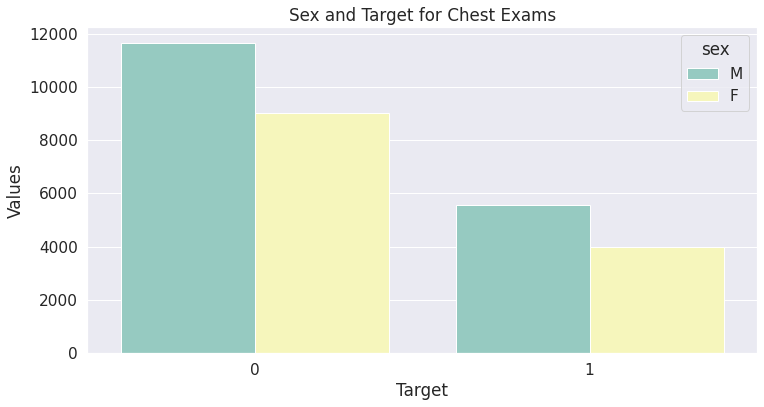

In [336]:
## Distbution of Sex Among the tragets
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and Target for Chest Exams')

## the number of males in both category are higher than women

Text(0.5, 1.0, 'Sex and class for Chest Exams')

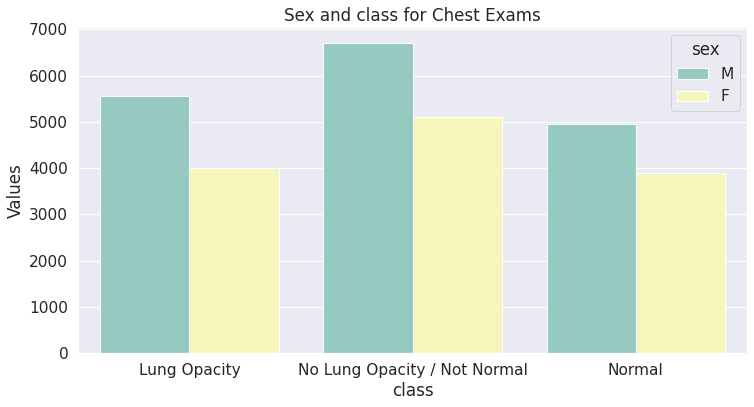

In [337]:
## Distbution of Sex Among the classes
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('class')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and class for Chest Exams')

## the number of males in all classes are higher than women

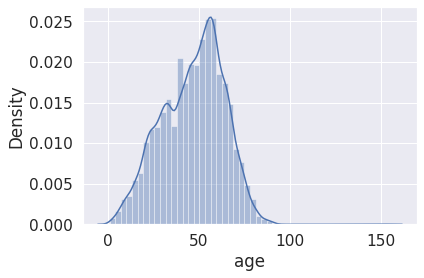

In [338]:
sns.distplot(training_data.age) 
# plots the distrubution of age
## Looks like normal distubution of age

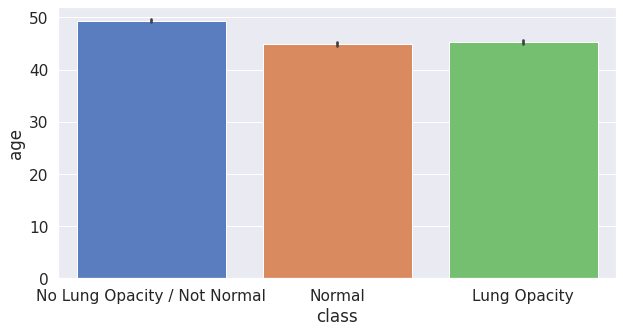

In [339]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='class', y='age', data=training_data, palette='muted')  # barplot'
## This is the distubution of Age with class, maximum age of person with pneuomina is arund 45

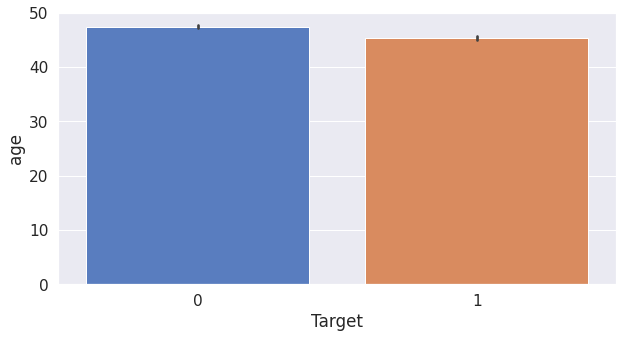

In [340]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='Target', y='age', data=training_data, palette='muted')  # barplot'
## This is the distubution of Age with class, maximum age of person with pneuomina is arund 45

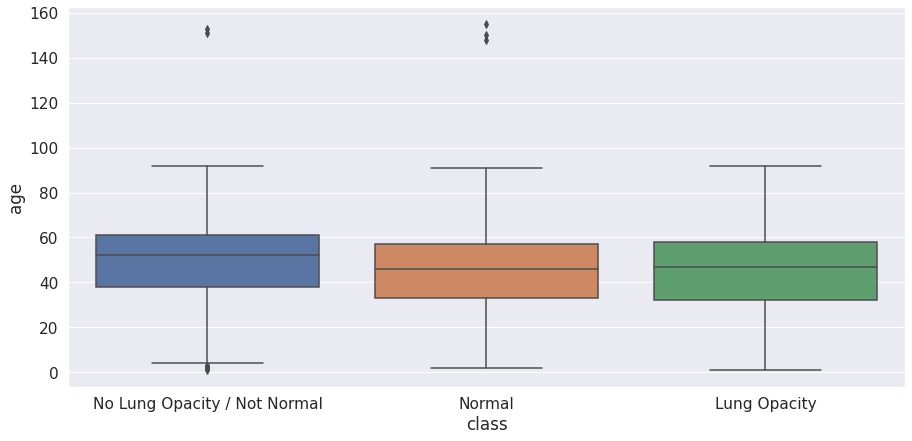

In [341]:
plt.figure(figsize=(15,7))
sns.boxplot(x='class', y='age', data= training_data)
plt.show()

## The  class which has no pneuomia has few outliers , theie age is somewhere aroun 150 years

Distribution of `Age`: Overall and Target = 1


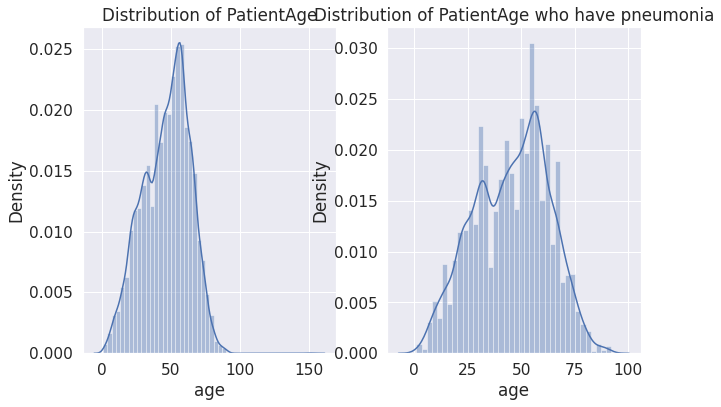

In [342]:
print('Distribution of `Age`: Overall and Target = 1')
fig = plt.figure(figsize = (10, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(training_data['age']).set_title('Distribution of PatientAge'))

ax = fig.add_subplot(122)
g = (sns.distplot(training_data.loc[training_data['Target'] == 1, 'age']).set_title('Distribution of PatientAge who have pneumonia'))

## Overall Distrubution of Age looks normal with very little skwe
## Distubution of Patients afe who have penuomonia are a left skewed 

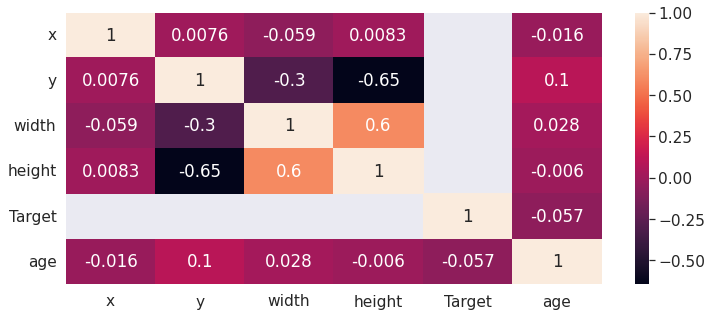

In [343]:
corr = training_data.corr()
plt.figure(figsize=(12,5))

sns.heatmap(corr,annot=True)

## There is high corelation between widht and height


### **MODEL BUILDING**

In [344]:
## Just taking a 200 samples from the dataset
sample_trainigdata = training_data.groupby('class', group_keys=False).apply(lambda x: x.sample(800))

In [345]:
## Checking the training data set with class distbution 
sample_trainigdata["class"].value_counts()

Lung Opacity                    800
No Lung Opacity / Not Normal    800
Normal                          800
Name: class, dtype: int64

In [346]:
sample_trainigdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 19348 to 3278
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  2400 non-null   object 
 1   x          800 non-null    float64
 2   y          800 non-null    float64
 3   width      800 non-null    float64
 4   height     800 non-null    float64
 5   Target     2400 non-null   int64  
 6   class      2400 non-null   object 
 7   sex        2400 non-null   object 
 8   age        2400 non-null   int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 187.5+ KB


In [347]:
## Pre Processing the image
from tensorflow.keras.applications.mobilenet import preprocess_input

images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the imahge and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = Base_path + 'stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels


In [348]:
## Reading the images into numpy array
images,labels = populateImage(sample_trainigdata)

In [349]:
images.shape , labels.shape
## The image is of 128*128 with 3 channels

((2400, 128, 128, 3), (2400,))

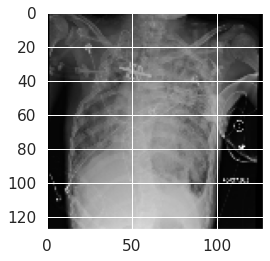

In [350]:
## Checking one of the converted image 
plt.imshow(images[100])

In [351]:
## check the unique labels
np.unique(labels),len(np.unique(labels))

(array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
       dtype='<U28'), 3)

In [352]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
# define model
from tensorflow.keras import losses,optimizers
from tensorflow.keras.layers import Dense,  Activation, Flatten,Dropout,MaxPooling2D,BatchNormalization
import pandas as pd
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
import matplotlib.pyplot as plt
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from sklearn.model_selection import StratifiedKFold
%matplotlib inline
#Test Train Split
from sklearn.model_selection import train_test_split
#Feature Scaling library
from sklearn.preprocessing import StandardScaler
#import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense ,LeakyReLU
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [353]:
## encoding the labels
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y2 = enc.fit_transform(labels)

In [354]:
## splitting into train ,test and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)



In [355]:
## FUnction to create a dataframe for results
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result


In [356]:
## CNN Model without transfer learning ,
## we start with 32 filters with 5,5 kernal and no padding , 
## then 64 and 128 wiht drop layers in between 
## And softmax activaation as the last layer
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [357]:
# Model Summary
cnn = cnn_model(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      2432      
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 64)        36928     
                                                      

In [358]:
## Training for 30 epocs with batch size of 30
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 30, 
                  validation_data = (X_val,y_val),
                  batch_size = 30)

Epoch 1/30
56/56 [==============================] - 3s 34ms/step - loss: 4.7667 - accuracy: 0.3351 - val_loss: 1.0845 - val_accuracy: 0.3667
Epoch 2/30
56/56 [==============================] - 2s 31ms/step - loss: 1.1192 - accuracy: 0.3702 - val_loss: 1.1227 - val_accuracy: 0.3222
Epoch 3/30
56/56 [==============================] - 2s 31ms/step - loss: 1.1122 - accuracy: 0.3375 - val_loss: 1.1041 - val_accuracy: 0.3889
Epoch 4/30
56/56 [==============================] - 2s 31ms/step - loss: 1.1020 - accuracy: 0.3792 - val_loss: 1.0756 - val_accuracy: 0.4194
Epoch 5/30
56/56 [==============================] - 2s 31ms/step - loss: 1.0940 - accuracy: 0.3929 - val_loss: 1.0701 - val_accuracy: 0.5083
Epoch 6/30
56/56 [==============================] - 2s 31ms/step - loss: 1.0749 - accuracy: 0.4226 - val_loss: 1.1240 - val_accuracy: 0.3222
Epoch 7/30
56/56 [==============================] - 2s 31ms/step - loss: 1.0501 - accuracy: 0.4446 - val_loss: 1.0540 - val_accuracy: 0.4083
Epoch 8/30
56

In [359]:
## evakualting the acuracy , we have only got accuracy of 43-46% where as the training accuracy is around 60%
fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

12/12 [==============================] - 0s 10ms/step - loss: 1.1120 - accuracy: 0.4722
Test loss: 1.111989974975586
Test accuracy: 0.4722222089767456


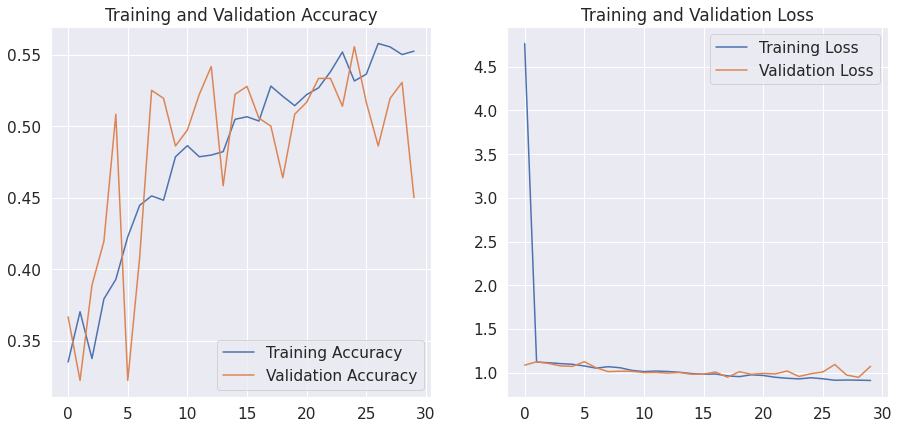

In [360]:
## PLottting the accuracy vs loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(30)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#The training and Validation loss is almost same, but for the training and validation accuracy chart, 
#the validation accuracy falls down in the later epochs, this could be because we have only taken 200 images for processing.

In [361]:
resultDF = createResultDf("CNN",acc[-1],fcl_accuracy)

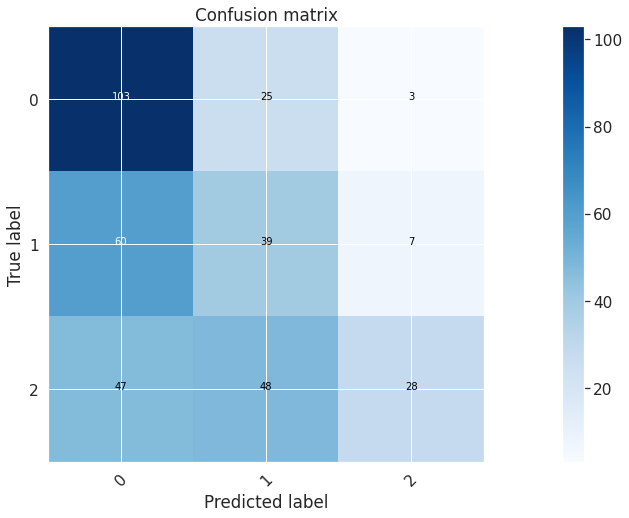

In [362]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

#Class 0 ,1 and 2
#Class 0 is Lung Opacity
#Class 1 is No Lung Opacity/Normal, the model has predicted mostly wrong in this case to the Target 0. Type 2 error
#Class 2 is Normal


In [363]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  1_support
0    CNN  0.552381    0.472222     0.348214  0.367925    0.357798        106

In [364]:
## Creating a Copy
X_train1 = X_train.copy()
X_val1 = X_val.copy()
X_test1 = X_test.copy()

**CNN with Tranfer learning using VGG16**

In [365]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

##VGGNet is a well-documented and globally used architecture for convolutional neural network
## Include_top=False to remove the classification layer that was trained on the ImageNet dataset and set the model as not trainable

base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)


In [366]:
## Adding two hidden later and one softmax layer as an output layer
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')


cnn_VGG16_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [367]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_VGG16_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Early stopping whe validation accuracy does not change for 7 iteration 
es = EarlyStopping(monitor='val_accuracy', mode='auto', patience=7,  restore_best_weights=True)

#Trainign the model
#history = cnn_VGG16_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val) ,callbacks=es)
history = cnn_VGG16_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val))

Epoch 1/30
53/53 [==============================] - 3s 39ms/step - loss: 1.2714 - accuracy: 0.5506 - val_loss: 0.6409 - val_accuracy: 0.6361
Epoch 2/30
53/53 [==============================] - 2s 34ms/step - loss: 0.4590 - accuracy: 0.7345 - val_loss: 0.6437 - val_accuracy: 0.6639
Epoch 3/30
53/53 [==============================] - 2s 34ms/step - loss: 0.3352 - accuracy: 0.8149 - val_loss: 0.6123 - val_accuracy: 0.6250
Epoch 4/30
53/53 [==============================] - 2s 34ms/step - loss: 0.2059 - accuracy: 0.9101 - val_loss: 0.6618 - val_accuracy: 0.6944
Epoch 5/30
53/53 [==============================] - 2s 34ms/step - loss: 0.1469 - accuracy: 0.9500 - val_loss: 0.6529 - val_accuracy: 0.6694
Epoch 6/30
53/53 [==============================] - 2s 34ms/step - loss: 0.1165 - accuracy: 0.9619 - val_loss: 0.7419 - val_accuracy: 0.6389
Epoch 7/30
53/53 [==============================] - 2s 34ms/step - loss: 0.0797 - accuracy: 0.9786 - val_loss: 0.7457 - val_accuracy: 0.6556
Epoch 8/30
53

In [368]:
test_ds = preprocess_input(X_test1) 
fcl_loss, fcl_accuracy = cnn_VGG16_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

## The Test accuracy score if 64% but the training accurayc is 100 , this model is overfit

12/12 [==============================] - 0s 27ms/step - loss: 1.1747 - accuracy: 0.6333
Test loss: 1.1746717691421509
Test accuracy: 0.6333333253860474


In [369]:
resultsDf1 = pd.concat([resultDF, createResultDf("CNN With VGG16",history.history['accuracy'][-1],fcl_accuracy)])


In [370]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf1[data+"_"+subData] = reportData[data][subData]

resultsDf1

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0             CNN  0.552381    0.472222     0.348214  0.367925    0.357798   
0  CNN With VGG16  1.000000    0.633333     0.348214  0.367925    0.357798   

   1_support  
0        106  
0        106

**CNN with ResNet50**

In [371]:
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

resnet_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=X_train[0].shape)
#model = VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))

train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')

cnn_resnet_model = models.Sequential([
    resnet_base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [372]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_resnet_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
history =cnn_resnet_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val))

Epoch 1/30
53/53 [==============================] - 11s 100ms/step - loss: 0.6364 - accuracy: 0.5565 - val_loss: 150.1105 - val_accuracy: 0.3389
Epoch 2/30
53/53 [==============================] - 4s 81ms/step - loss: 0.4891 - accuracy: 0.6417 - val_loss: 2.1864 - val_accuracy: 0.3750
Epoch 3/30
53/53 [==============================] - 4s 81ms/step - loss: 0.4695 - accuracy: 0.6440 - val_loss: 0.8023 - val_accuracy: 0.5417
Epoch 4/30
53/53 [==============================] - 4s 81ms/step - loss: 0.4501 - accuracy: 0.6804 - val_loss: 0.7970 - val_accuracy: 0.5528
Epoch 5/30
53/53 [==============================] - 4s 81ms/step - loss: 0.4037 - accuracy: 0.7048 - val_loss: 0.7922 - val_accuracy: 0.5833
Epoch 6/30
53/53 [==============================] - 4s 81ms/step - loss: 0.3642 - accuracy: 0.7512 - val_loss: 0.9936 - val_accuracy: 0.5111
Epoch 7/30
53/53 [==============================] - 4s 81ms/step - loss: 0.3600 - accuracy: 0.7637 - val_loss: 0.6201 - val_accuracy: 0.5333
Epoch 8/3

In [373]:
fcl_loss, fcl_accuracy = cnn_resnet_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

## Thw accuracy of test score is 58% abut training accuracy is 99% again it is an overfit model


12/12 [==============================] - 1s 24ms/step - loss: 1.0424 - accuracy: 0.5139
Test loss: 1.042396068572998
Test accuracy: 0.5138888955116272


In [374]:
history.history['accuracy'][-1]

0.963690459728241

In [375]:
resultsDf2 = pd.concat([resultsDf1, createResultDf("CNN With ResNet50",history.history['accuracy'][-1],fcl_accuracy)])


In [376]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultsDf2[data+"_"+subData] = reportData[data][subData]



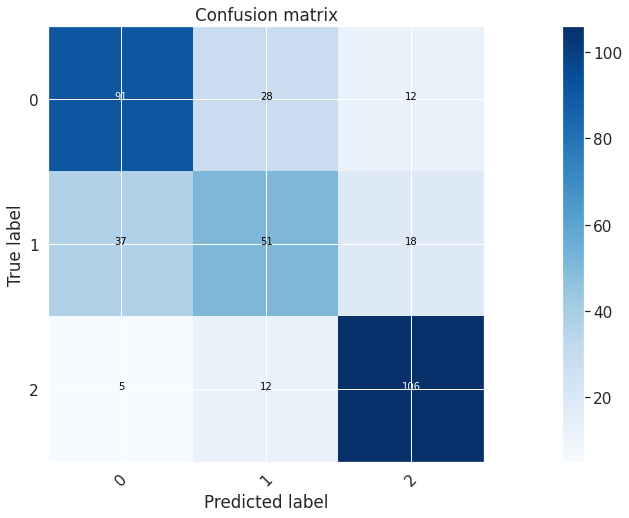

In [377]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
# Predict the values from the validation dataset
Y_pred = cnn_resnet_model.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [378]:
resultsDf2.head()
## with transfer learning we have the issue of overfitting, it does well in the training data set but not well in test
## Without TRansfer learning , the accuracy is not high but the model is general
## We will need to pre process tha image further and take more sample to conclude 

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0                CNN  0.552381    0.472222     0.348214  0.367925    0.357798   
0     CNN With VGG16  1.000000    0.633333     0.348214  0.367925    0.357798   
0  CNN With ResNet50  0.963690    0.513889     0.348214  0.367925    0.357798   

   1_support  
0        106  
0        106  
0        106

# Bounding Box Prediction : UNet

In [379]:
labels = pd.read_csv(Base_path + "stage_2_train_labels.csv")


In [380]:
## Getting the first 5000 data set for traingin and the next 5000 for validations
train_CombinedData = labels[0:5000]
validate_CombinedData = labels[5000:10000]

train_CombinedData.fillna(0, inplace=True)
validate_CombinedData.fillna(0, inplace=True)


In [381]:
## Checking training data distuburtion , they have almos the same target distubution
train_CombinedData.Target.value_counts()

0    2633
1    2367
Name: Target, dtype: int64

# ** Creating Custom Train Generator. This will read the files in batches of 10 while training the model**

In [382]:
from tensorflow.keras.applications.mobilenet import preprocess_input 

#
BATCH_SIZE = 10

## Image Size to be scaled
IMAGE_SIZE = 224


## Actual Image size 
IMG_WIDTH = 1024
IMG_HEIGHT = 1024


class TrainGenerator(Sequence):

    def __init__(self,  _labels):       
        self.pids = _labels["patientId"].to_numpy()
        self.coords = _labels[["x", "y", "width", "height"]].to_numpy()
        self.coords = self.coords * IMAGE_SIZE / IMG_WIDTH
        

    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)
    
    
    """
    The contrast of an image is enhanced when various shades in the image becomes more distinct.
    We can do so by darkening the shades of the darker pixels and vice versa. 
    This is equivalent to widening the range of pixel intensities. To have a good contrast, 
    the following histogram characteristics are desirable:

    1) the pixel intensities are uniformly distributed across the full range of values (each intensity value is equally probable), and
    2) the cumulative histogram is increasing linearly across the full intensity range.

    Histogram equalization modifies the distribution of pixel intensities to achieve these characteristics.
    """

    def __doHistogramEqualization(self,img):
        # Pre processing Histogram equalization
        histogram_array = np.bincount(img.flatten(), minlength=256)
        #normalize
        num_pixels = np.sum(histogram_array)
        histogram_array = histogram_array/num_pixels
        #normalized cumulative histogram
        chistogram_array = np.cumsum(histogram_array)
        """
        STEP 2: Pixel mapping lookup table
        """
        transform_map = np.floor(255 * chistogram_array).astype(np.uint8)
        """
        STEP 3: Transformation
        """
        img_list = list(img.flatten())

        # transform pixel values to equalize
        eq_img_list = [transform_map[p] for p in img_list]

        # reshape and write back into img_array
        img = np.reshape(np.asarray(eq_img_list), img.shape)

        return img

    def __getitem__(self, idx): # Get a batch
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords
        batch_pids = self.pids[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image pids    
        
        batch_images = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE))
        for _indx, _pid in enumerate(batch_pids):
            _path = Base_path + 'stage_2_train_images/'+'{}.dcm'.format(_pid)
            _imgData = dcm.read_file(_path)

            img = _imgData.pixel_array 
#             img = np.stack((img,)*3, axis=-1) # Expand grayscale image to contain 3 channels

            # Resize image
            resized_img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_AREA)
            
            resized_img = self.__doHistogramEqualization(resized_img)
        
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2])
            height = int(batch_coords[_indx, 3])
            
            batch_masks[_indx][y:y+height, x:x+width] = 1

        return batch_images, batch_masks

In [383]:
trainUNetDataGen = TrainGenerator( train_CombinedData)
validateUNetDataGen = TrainGenerator( validate_CombinedData)


In [384]:
# To show image with mask
def showMaskedImage(_imageSet, _maskSet, _index) :
    maskImage = _imageSet[_index]

    maskImage[:,:,0] = _maskSet[_index] * _imageSet[_index][:,:,0]
    maskImage[:,:,1] = _maskSet[_index] * _imageSet[_index][:,:,1]
    maskImage[:,:,2] = _maskSet[_index] * _imageSet[_index][:,:,2]

    plt.imshow(maskImage[:,:,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


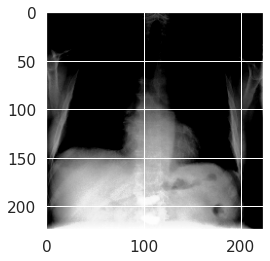

In [385]:
## One of the pre processed image from custom train generotr
imageSet0 = trainUNetDataGen[1][0][1]
plt.imshow(imageSet0)

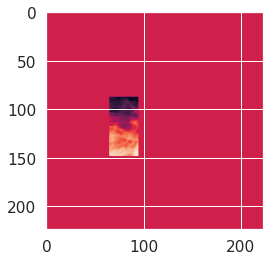

In [386]:
## Masks for the same
imageSet0 = trainUNetDataGen[2][0]
maskSet0 = trainUNetDataGen[2][1]    
showMaskedImage(imageSet0, maskSet0, 5)

In [387]:
LR = 1e-4

In [388]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization ,Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet , VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D


**UNET USING MobileNet**

In [389]:
ALPHA = 1.0
def create_UNetModelUsingMobileNet(trainable=True):
    """Function to create UNet architecture with MobileNet.
        
    Arguments:
        trainable -- Flag to make layers trainable. Default value is 'True'.
    """
    # Get all layers with 'imagenet' weights
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet") 
    # Top layer is last layer of the model
    
    # Make all layers trainable
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    convLayer_112by112 = model.get_layer("conv_pw_1_relu").output
    convLayer_56by56 = model.get_layer("conv_pw_3_relu").output
    convLayer_28by28 = model.get_layer("conv_pw_5_relu").output
    convLayer_14by14 = model.get_layer("conv_pw_11_relu").output
    convLayer_7by7 = model.get_layer("conv_pw_13_relu").output
    # The last layer of mobilenet model is of dimensions (7x7x1024)

    # Start upsampling from 7x7 to 14x14 ...up to 224x224 to form UNET
    # concatinate with the original image layer of the same size from MobileNet
    x = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    x = Concatenate()([UpSampling2D()(x), convLayer_28by28])
    x = Concatenate()([UpSampling2D()(x), convLayer_56by56])
    x = Concatenate()([UpSampling2D()(x), convLayer_112by112])
    x = UpSampling2D(name="unet_last")(x) # upsample to 224x224

    # Add classification layer
    x = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(x)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x) 

    return Model(inputs=model.input, outputs=x)

In [390]:
## Build a model 
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
model = create_UNetModelUsingMobileNet(input_shape)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                           

In [391]:
#dice_coef 2 * the Area of Overlap divided by the total number of pixels in both images
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + tf.keras.backend.epsilon()) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())

## Loss is 1 - the coefficent of two images
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [392]:
## Call Backs for ealy stopping and reduce learning rate 
## Reduce the learning rate when teh validation loss is same for 4 epocs
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [393]:
## Optimiser , metrics and loss for the model
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)


In [394]:
## Running the model
train_steps = len(trainUNetDataGen)//BATCH_SIZE
valid_steps = len(validateUNetDataGen)//BATCH_SIZE

if len(trainUNetDataGen) % BATCH_SIZE != 0:
    train_steps += 1
if len(validateUNetDataGen) % BATCH_SIZE != 0:
    valid_steps += 1


history = model.fit(trainUNetDataGen,
                        epochs=16,
                        steps_per_epoch=train_steps,
                        validation_data=validateUNetDataGen,
                        callbacks=callbacks,
                        use_multiprocessing=True,
                        workers=4,
                        validation_steps=valid_steps,                      
                        shuffle=True)


Epoch 1/16
50/50 [==============================] - 36s 560ms/step - loss: 0.8460 - dice_coef: 0.1540 - recall_2: 0.7787 - precision_2: 0.0814 - val_loss: 0.8898 - val_dice_coef: 0.1102 - val_recall_2: 0.8016 - val_precision_2: 0.0724 - lr: 1.0000e-04
Epoch 2/16
50/50 [==============================] - 24s 473ms/step - loss: 0.7165 - dice_coef: 0.2835 - recall_2: 0.5978 - precision_2: 0.2112 - val_loss: 0.8286 - val_dice_coef: 0.1714 - val_recall_2: 0.5843 - val_precision_2: 0.1484 - lr: 1.0000e-04
Epoch 3/16
50/50 [==============================] - 28s 540ms/step - loss: 0.6735 - dice_coef: 0.3265 - recall_2: 0.5143 - precision_2: 0.2821 - val_loss: 0.8328 - val_dice_coef: 0.1672 - val_recall_2: 0.5532 - val_precision_2: 0.1394 - lr: 1.0000e-04
Epoch 4/16
50/50 [==============================] - 28s 541ms/step - loss: 0.6630 - dice_coef: 0.3370 - recall_2: 0.4949 - precision_2: 0.2827 - val_loss: 0.8329 - val_dice_coef: 0.1671 - val_recall_2: 0.6812 - val_precision_2: 0.1291 - lr: 1.0

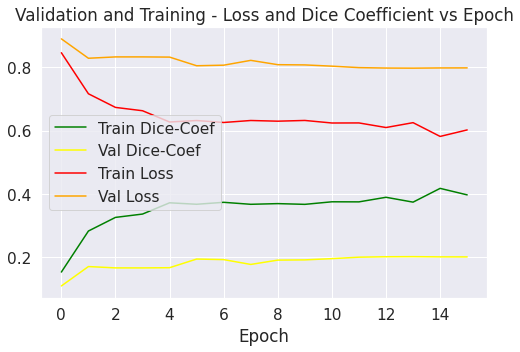

In [395]:
## PLot Matrix between training and validation data
plt.figure(figsize=(8, 5))
plt.grid(True)
plt.plot(history.history['dice_coef'],     label='Train Dice-Coef',      color = "green" );
plt.plot(history.history['val_dice_coef'], label='Val Dice-Coef',  color = "yellow");
plt.plot(history.history['loss'],         label='Train Loss',          color = "red"   );
plt.plot(history.history['val_loss'],     label='Val Loss',      color = "orange");
plt.title("Validation and Training - Loss and Dice Coefficient vs Epoch")
plt.xlabel("Epoch")
plt.legend();

val_dice-oefficient value is very low and pretty much a flat curve, indicating underfitting indicating model has not learnt sufficiently. It is steadily increasing, not sufficient training(more epochs needed).  

We have used an image size of 224x224 as against the original size of 1024x1024. Using a higher resolution, could also improve training capacity 

<li>Hyper-parameter tuning, image_augmentation, using different architectures will help in increasing model performance and generalization.


In [396]:
##Preparing test data , picked up random 100 images
test_CombinedData = labels[15000:15100]
test_CombinedData.fillna(0, inplace=True)

In [397]:
##Check target distrubution in test dataset, there are both the classes available with equal sdistrubution
test_CombinedData.Target.value_counts()

0    64
1    36
Name: Target, dtype: int64

In [398]:
## Setting the custom generator for test data
testUNetDataGen = TrainGenerator(test_CombinedData)

In [399]:
## evaluating the model
test_steps = (len(testUNetDataGen)//BATCH_SIZE)
if len(testUNetDataGen) % BATCH_SIZE != 0:
    test_steps += 1

score = model.evaluate(testUNetDataGen)

## Model evaluation , dice coef = 50% m recall is good  wiht 61% , precission is very low , of about 43.37%

10/10 [==============================] - 3s 250ms/step - loss: 0.5909 - dice_coef: 0.4091 - recall_2: 0.4821 - precision_2: 0.4052


In [400]:
print (score)

[0.5908868908882141, 0.40911316871643066, 0.48213866353034973, 0.4052044451236725]


In [401]:
## Precidt the test data that we have
pred_mask = model.predict(testUNetDataGen)


In [402]:
test_CombinedData = test_CombinedData.reset_index()


In [403]:
from sklearn.metrics import confusion_matrix
y_pred = []
y_True = []
imageList = []
predMaskTemp = []
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
def getPredictions(test_CombinedData):
    masks = np.zeros((int(test_CombinedData.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))

    for index, row in test_CombinedData.iterrows():
        patientId = row.patientId
#         print(patientId)

        classlabel = row["Target"]
        dcm_file = Base_path + 'stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        resized_img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH), interpolation = cv2.INTER_LINEAR)
        predMaskTemp.append(pred_mask[index])
        iou = (pred_mask[index] > 0.5) * 1.0
        y_pred.append((1 in iou) * 1)
        imageList.append(resized_img)
        y_True.append(classlabel)
        x_scale = IMAGE_HEIGHT / 1024
        y_scale = IMAGE_WIDTH / 1024

        if(classlabel == 1):
            x = int(np.round(row['x'] * x_scale))
            y = int(np.round(row['y'] * y_scale))
            w = int(np.round(row['width'] * x_scale))
            h = int(np.round(row['height'] * y_scale))
            masks[index][y:y+h, x:x+w] = 1

        
        
    tmpImages = np.array(imageList)
    tmpMask = np.array(predMaskTemp)
    originalMask = np.array(masks)
    return (y_True,y_pred,tmpImages,tmpMask ,originalMask)
    
def print_confusion_matrix(y_true, y_pred):
    '''Function to print confusion_matrix'''

    # Get confusion matrix array
    array = confusion_matrix(y_true, y_pred)    
    df_cm = pd.DataFrame(array, range(2), range(2))

    print("Total samples = ", len(test_CombinedData))

    # Plot heatmap and get sns heatmap values
    sns.set(font_scale=1.4); # for label size
    result = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cbar=False); 

    # Add labels to heatmap
    labels = ['TN=','FP=','FN=','TP=']
    i=0
    for t in result.texts:
        t.set_text(labels[i] + t.get_text())
        i += 1
    
    plt.xlabel("Predicted Values")
    plt.ylabel('True Values')
    plt.show()
    return
    

    


In [404]:
## Create predictions map
y_true,y_pred ,imagelist , maskList , originalMask = getPredictions(test_CombinedData)


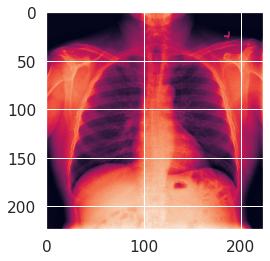

In [405]:

dcm_file = Base_path + 'stage_2_train_images/'+'{}.dcm'.format('9358d1c5-ba61-4150-a233-41138208a3f9')
dcm_data = dcm.read_file(dcm_file)
img = dcm_data.pixel_array
plt.imshow(imagelist[12])

Text(0.5, 0, 'Pneumonia 1:')

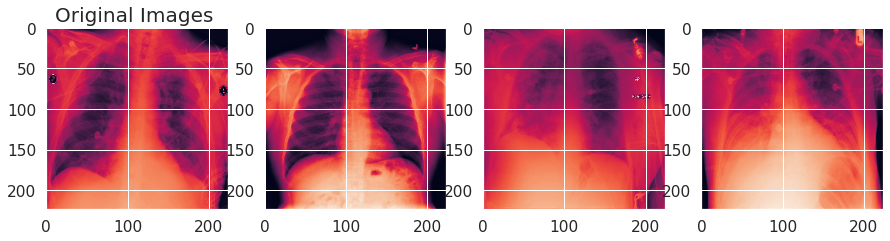

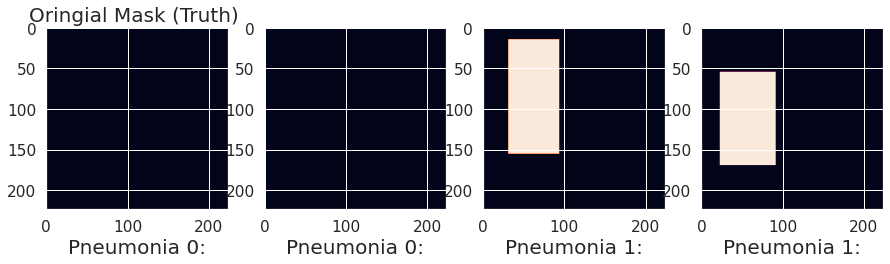

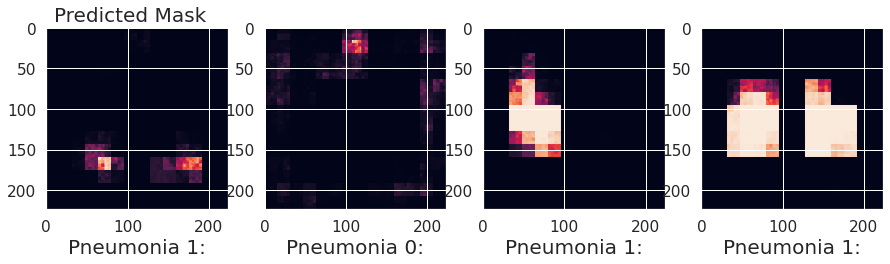

In [406]:
## Visualising the train and output data 
##
fig = plt.figure(figsize=(15, 15))

a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(imagelist[1])
a.set_title('Original Images ',fontsize=20)


a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(imagelist[12])

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(imagelist[13])

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(imagelist[15])


fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)

imgplot = plt.imshow(originalMask[1])
a.set_title('Oringial Mask (Truth) ',fontsize=20)

a.set_xlabel('Pneumonia {}:'.format(y_true[1]), fontsize=20)


a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(originalMask[12])
a.set_xlabel('Pneumonia {}:'.format(y_true[12]), fontsize=20)


a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(originalMask[13])
a.set_xlabel('Pneumonia {}:'.format(y_true[13]), fontsize=20)


a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(originalMask[15])
a.set_xlabel('Pneumonia {}:'.format(y_true[15]), fontsize=20)



fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
a.set_title('Predicted Mask  ',fontsize=20)
imgplot = plt.imshow(maskList[1])
a.set_xlabel('Pneumonia {}:'.format(y_pred[1]), fontsize=20)

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(maskList[12])
a.set_xlabel('Pneumonia {}:'.format(y_pred[12]), fontsize=20)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(maskList[13])
a.set_xlabel('Pneumonia {}:'.format(y_pred[13]), fontsize=20)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(maskList[15])
a.set_xlabel('Pneumonia {}:'.format(y_pred[15]), fontsize=20)


## we could see that the first  one is mis classifed
## Second one is classified correctly , there are no masks
## Thrid is predcited correctly and the bouding box is also almost at the same position
## fourth is predicted correctly but there are two boudnign boxes, this culd be because there are duplicate patient id and we are picking only one mask to display inte Truth

In [407]:
#Y_pred_new = np.select([Y_pred <= .3, Y_pred>.7], [np.zeros_like(Y_pred), np.ones_like(Y_pred)])
Y_pred_rounded = np.argmax(Y_pred, axis=1)

In [408]:


reportData = classification_report(Y_true, Y_pred_rounded)

print (reportData)


              precision    recall  f1-score   support

           0       0.68      0.69      0.69       131
           1       0.56      0.48      0.52       106
           2       0.78      0.86      0.82       123

    accuracy                           0.69       360
   macro avg       0.67      0.68      0.68       360
weighted avg       0.68      0.69      0.68       360



Total samples =  100


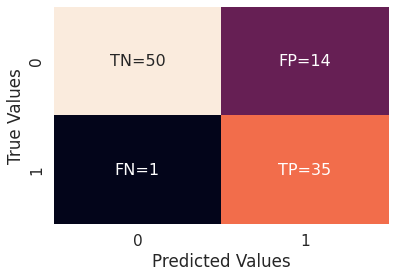

In [409]:
print_confusion_matrix(y_true,y_pred )
## There are two False Postive for Target 1

In [410]:
from sklearn.metrics import classification_report

reportData = classification_report(y_true,y_pred, output_dict = True)

print (reportData)



{'0': {'precision': 0.9803921568627451, 'recall': 0.78125, 'f1-score': 0.8695652173913042, 'support': 64}, '1': {'precision': 0.7142857142857143, 'recall': 0.9722222222222222, 'f1-score': 0.8235294117647058, 'support': 36}, 'accuracy': 0.85, 'macro avg': {'precision': 0.8473389355742297, 'recall': 0.8767361111111112, 'f1-score': 0.846547314578005, 'support': 100}, 'weighted avg': {'precision': 0.884593837535014, 'recall': 0.85, 'f1-score': 0.8529923273657287, 'support': 100}}


In [411]:
resultsDf3 = createResultDf("UNET",0.88,0.88)

In [412]:
for data in reportData:
    if(data == '1'):
      if(type(reportData[data]) is dict):
        for subData in reportData[data]:
           resultsDf3[data+"_"+subData] = reportData[data][subData]

resultsDf3


Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  1_support
0   UNET      0.88        0.88     0.714286  0.972222    0.823529         36

In [413]:
resultsDfFinal = pd.concat([resultsDf2,resultsDf3])

resultsDfFinal

Method  accuracy  Test Score  1_precision  1_recall  1_f1-score  \
0                CNN  0.552381    0.472222     0.348214  0.367925    0.357798   
0     CNN With VGG16  1.000000    0.633333     0.348214  0.367925    0.357798   
0  CNN With ResNet50  0.963690    0.513889     0.348214  0.367925    0.357798   
0               UNET  0.880000    0.880000     0.714286  0.972222    0.823529   

   1_support  
0        106  
0        106  
0        106  
0         36

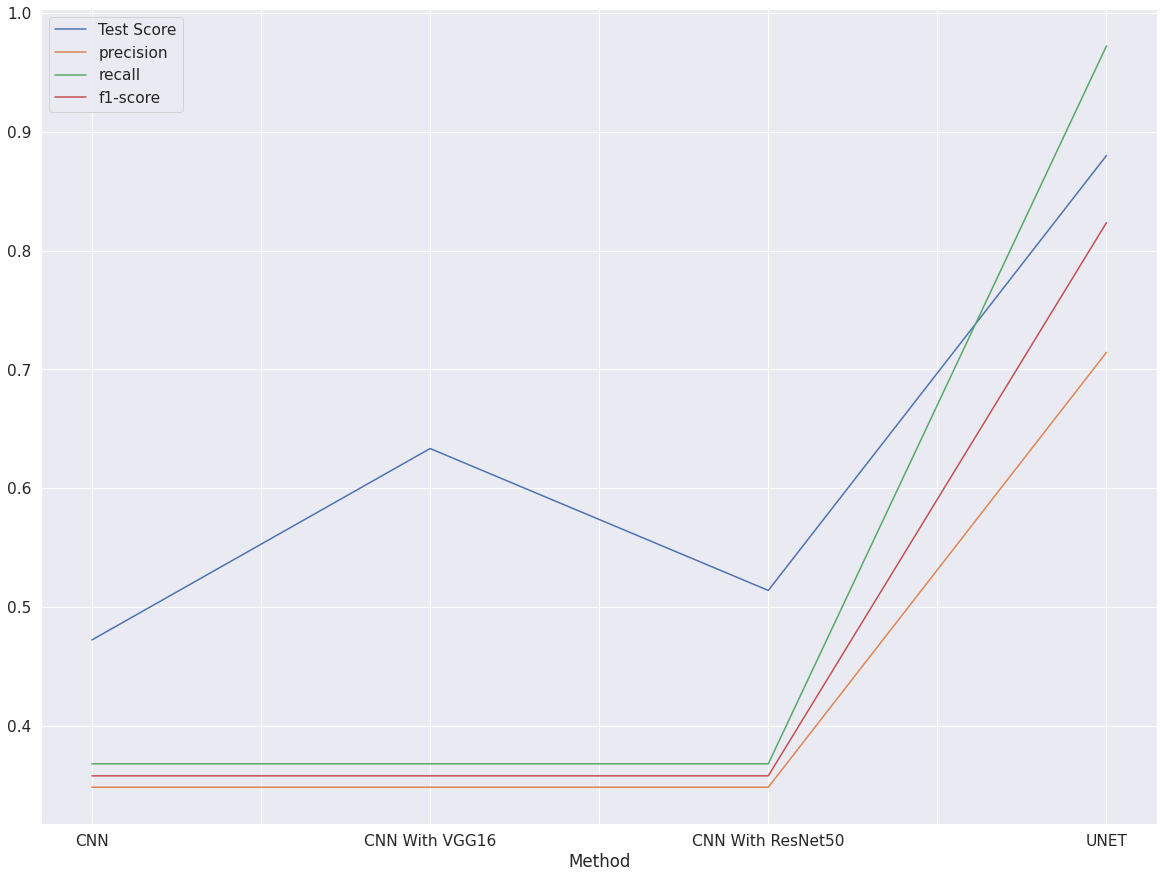

In [429]:
resultsDfFinal.rename(columns={'1_precision': 'precision', '1_recall': 'recall','1_f1-score': 'f1-score'}, inplace=True)

resultsDfFinal.plot(x="Method", y=["Test Score","precision","recall","f1-score"], figsize=(20, 15))

plt.show()

<font color=red> 
    <li>Recall socre is quite high for pneumonia class(target = 1), even for a very low dice-coefficient score for image mask prediction. This is a good score, because it indicates that 99% of patients who are positive are detected correctly by this model. 
    <li>Precision score is however low indicating only 83% of the predictions are correct. This is largely due to a high amount of false positives, as indicated in the confusion matrix.
    <li>The accuracy score is  0.85%, w This probably can improve as the model trains with more number of samples, that will help it to distinguish non-pneumonia images better.

1)	We have done the EDA 

2)	We have done the pre-processing of the dicom images

3)	We have built CNN model for classification without transfer learning and with Transfer learning

4)	Currently with the limited sample data set that we have taken we have found the CNN model without transfer learning was the most general model even though the accuracy was not very high

5)	We have built UNET model for regression using VGG16 Pre trained model 

6) We can improve the dice loss by image augmentation , increasing the sample size and hyper tuning
